In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cython.parallel as parallel

In [20]:
gamma=0.9
actual_theta = [0.6, 1]
N = 25
arms = [1,2]
actual_best = 2

intuitive_regret = np.zeros(N)
bayesian_regret = np.zeros(N)

test_round = 50
# EstimatedReward1 = [[0 for i in range(test_round)] for j in range(test_round)]
# EstimatedReward2 = [[0 for i in range(test_round)] for j in range(test_round)]
R_result=[[[[-1 for j4 in range(test_round)] for j3 in range(test_round)] for j2 in range(test_round)] for j1 in range(test_round)]
R_choose=[[[[-1 for j4 in range(test_round)] for j3 in range(test_round)] for j2 in range(test_round)] for j1 in range(test_round)]

In [21]:
def reward_part2(choose,time):
    # choose: 0,1
    probability = actual_theta[choose]
    if (random.uniform(0, 1) < probability):
        return gamma**time
    else:
        return 0

In [22]:
def R(a1, b1, a2, b2):
    if(a1>=test_round or a2>=test_round or b1 >= test_round or b2>=test_round):
        return 0
    if R_result[a1][b1][a2][b2]!=-1:
        return R_result[a1][b1][a2][b2]
    else:
        r = np.array([R1(a1,b1,a2,b2),R2(a1,b1,a2,b2)])
        # print(r)
        if r[0]==r[1]:
            R_choose[a1][b1][a2][b2]=0
        else:
            R_choose[a1][b1][a2][b2]=np.argmax(r)+1
            # print(np.argmax(r)+1)
        # if a1<3 and a2<3 and b1<3 and b2<3:
        #     print(a1,b1,a2,b2,r,"choose",str(R_choose[a1][b1][a2][b2]))
        R_result[a1][b1][a2][b2]=max(r)
        # print(a1,b1,a2,b2,R_result[a1][b1][a2][b2])
        return R_result[a1][b1][a2][b2]

def R1(a1, b1, a2, b2):
    c=a1/(a1+b1)
    return c*(1+gamma*R(a1+1,b1,a2,b2))+(1-c)*(gamma*R(a1,b1+1,a2,b2))

def R2(a1, b1, a2, b2):
    c=a2/(a2+b2)
    return c*(1+gamma*R(a1,b1,a2+1,b2))+(1-c)*(gamma*R(a1,b1,a2,b2+1))

# def R1(a1, b1, a2, b2):
#     if EstimatedReward1[a1][b1] != 0:
#         return EstimatedReward1[a1][b1]
#     if a1==test_round-1 and b1==test_round-1:
#         EstimatedReward1[a1][b1] = 1/2
#     elif a1==test_round-1:
#         r = R(a1, b1 + 1, a2, b2)
#         EstimatedReward1[a1][b1] = a1/(a1+b1) + (b1*gamma*r)/(a1+b1)
#     elif b1==test_round-1:
#         r = R(a1 + 1, b1, a2, b2)
#         EstimatedReward1[a1][b1] = (a1*(1+gamma*r))/(a1+b1)
#     else:
#         r1 = R(a1, b1 + 1, a2, b2)
#         r2 = R(a1 + 1, b1, a2, b2)
#         EstimatedReward1[a1][b1] = (a1*(1+gamma*r2))/(a1+b1) + (b1*gamma*r1)/(a1+b1)
#     return EstimatedReward1[a1][b1]
#
# def R2(a1, b1, a2, b2):
#     if EstimatedReward1[a2][b2] != 0:
#         return EstimatedReward1[a2][b2]
#     if a2==test_round-1 and b2==test_round-1:
#         EstimatedReward2[a2][b2] = 1/2
#     elif a2==test_round-1:
#         r = R(a1, b1, a2, b2 + 1)
#         EstimatedReward2[a2][b2] = a2/(a2+b2) + (b2*gamma*r)/(a2+b2)
#     elif b2==test_round-1:
#         r = R(a1, b1, a2 + 1, b2)
#         EstimatedReward2[a2][b2] = (a2*(1+gamma*r))/(a2+b2)
#     else:
#         r1 = R(a1, b1, a2, b2 + 1)
#         r2 = R(a1, b1, a2 + 1, b2)
#         EstimatedReward2[a2][b2] = (a2*(1+gamma*r2))/(a2+b2) + (b2*gamma*r1)/(a2+b2)
#     return EstimatedReward1[a2][b2]

In [23]:
def Part2(N,arms):
    #initialize:

    # I_t = -1
    #idx here all start from 0
    count = [0 for i in range(len(arms))]
    theta = [0.5 for i in range(len(arms))]
    ab = [[1,1] for arm in arms]

    total_reward = 0
    
    current_regret = np.zeros(N)

    for t in range(N):
        #choose and pull arm

        if(theta[0]==theta[1]):
            I_t=random.randint(0,1)
        else:
            I_t = np.argmax(theta)
        if t==0:
            current_regret[t] = actual_theta[actual_best-1] - actual_theta[I_t]
        else:
            current_regret[t] = current_regret[t-1] + actual_theta[actual_best-1] - actual_theta[I_t]
        # print(I_t)
        r = reward_part2(I_t,t)
        total_reward+=r
        count[I_t] +=1
        if(r!= 0):
            ab[I_t][0]+=1
        else:
            ab[I_t][1]+=1
        #更新theta
        theta = [float(a) / (a + b) for a, b in ab]
        # for t in arms:
        #     theta[t] = ab[I_t][0]/(ab[I_t][0]+ab[I_t][1])
    
    global intuitive_regret
    intuitive_regret += current_regret
    return total_reward

In [24]:
def R_part2(N):
    total_reward = 0.0
    a = [1,1]
    b = [1,1]
    current_regret = np.zeros(N)
    for n in range(N):
        arm_choose = R_choose[a[0]][b[0]][a[1]][b[1]]
        if arm_choose==0:
            arm_choose=random.randint(1,2)
        # print(arm_choose)
        if n==0:
            current_regret[n] = actual_theta[actual_best-1] - actual_theta[arm_choose-1]
        else:
            current_regret[n] = current_regret[n-1] + actual_theta[actual_best-1] - actual_theta[arm_choose-1]
        r = reward_part2(arm_choose-1,n)
        if(r != 0):
            a[arm_choose-1] += 1
        else:
            b[arm_choose-1] += 1
        total_reward += r
    global bayesian_regret
    bayesian_regret += current_regret
    return total_reward

In [25]:
R(1,1,1,1)
result1 = 0
result2 = 0
times=2000

In [32]:
actual_theta = [0.7, 0.3]
result1 = 0
result2 = 0
times=2000
intuitive_regret = np.zeros(N)
bayesian_regret = np.zeros(N)
for n in parallel.prange(times):
    result1 += Part2(N,arms)
print("actual theta",actual_theta)
print(result1/times)

actual theta [0.7, 0.3]
5.7321382028875405


In [33]:
actual_theta = [0.4, 0.5]
result1 = 0
result2 = 0
times=2000
intuitive_regret = np.zeros(N)
bayesian_regret = np.zeros(N)
for n in parallel.prange(times):
    result1 += Part2(N,arms)
print("actual theta",actual_theta)
print(result1/times)

actual theta [0.4, 0.5]
4.194050733784948


In [34]:
actual_theta = [0.1, 0.3]
result1 = 0
result2 = 0
times=2000
intuitive_regret = np.zeros(N)
bayesian_regret = np.zeros(N)
for n in parallel.prange(times):
    result1 += Part2(N,arms)
print("actual theta",actual_theta)
print(result1/times)

actual theta [0.1, 0.3]
2.189483136796276


actual theta [0.6, 1]
8.428220948879428
8.700365497940021


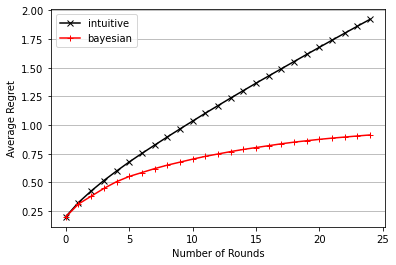

In [26]:
actual_theta = [0.6, 0.1]
result1 = 0
result2 = 0
times=2000
intuitive_regret = np.zeros(N)
bayesian_regret = np.zeros(N)
for n in parallel.prange(times):
    result1 += Part2(N,arms)

    r2=R_part2(N)
    result2 += r2
    # print(r2)
print("actual theta",actual_theta)
print(result1/times)
print(result2/times)

bayesian_regret /= times
intuitive_regret /= times

spacing = 1
plt.plot(range(0, 25)[::spacing], intuitive_regret[::spacing], label='intuitive', color='black', marker='x')
plt.plot(range(0, 25)[::spacing], bayesian_regret[::spacing], label='bayesian', color='red', marker='+')
plt.legend()
plt.grid(True, axis='y')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Regret')
plt.show()

actual theta [0.2, 0.3]
2.3358951039938107
2.4041520918873154


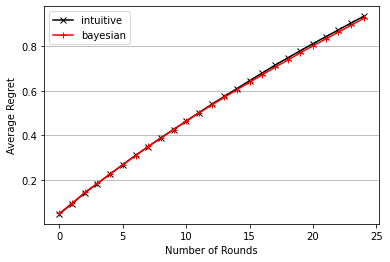

In [36]:
actual_theta = [0.2, 0.3]
result1 = 0
result2 = 0
times=2000
intuitive_regret = np.zeros(N)
bayesian_regret = np.zeros(N)
for n in parallel.prange(times):
    result1 += Part2(N,arms)

    r2=R_part2(N)
    result2 += r2
    # print(r2)
print("actual theta",actual_theta)
print(result1/times)
print(result2/times)

bayesian_regret /= times
intuitive_regret /= times

spacing = 1
plt.plot(range(0, 25)[::spacing], intuitive_regret[::spacing], label='intuitive', color='black', marker='x')
plt.plot(range(0, 25)[::spacing], bayesian_regret[::spacing], label='bayesian', color='red', marker='+')
plt.legend()
plt.grid(True, axis='y')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Regret')
plt.show()

actual theta [0.3, 0.8]
6.673951735961105
6.71468886789944


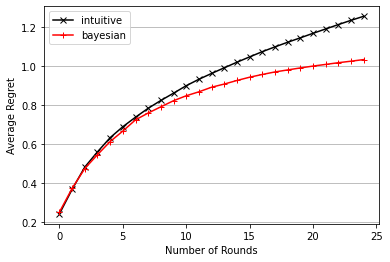

In [28]:
actual_theta = [0.3, 0.8]
result1 = 0
result2 = 0
times=2000
intuitive_regret = np.zeros(N)
bayesian_regret = np.zeros(N)
for n in parallel.prange(times):
    result1 += Part2(N,arms)

    r2=R_part2(N)
    result2 += r2
    # print(r2)
print("actual theta",actual_theta)
print(result1/times)
print(result2/times)

bayesian_regret /= times
intuitive_regret /= times

spacing = 1
plt.plot(range(0, 25)[::spacing], intuitive_regret[::spacing], label='intuitive', color='black', marker='x')
plt.plot(range(0, 25)[::spacing], bayesian_regret[::spacing], label='bayesian', color='red', marker='+')
plt.legend()
plt.grid(True, axis='y')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Regret')
plt.show()

actual theta [0.8, 0.9]
7.975939447931294
7.997794253615538


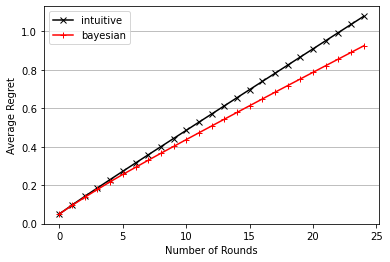

In [37]:
actual_theta = [0.8, 0.9]
result1 = 0
result2 = 0
times=2000
intuitive_regret = np.zeros(N)
bayesian_regret = np.zeros(N)
for n in parallel.prange(times):
    result1 += Part2(N,arms)

    r2=R_part2(N)
    result2 += r2
    # print(r2)
print("actual theta",actual_theta)
print(result1/times)
print(result2/times)

bayesian_regret /= times
intuitive_regret /= times

spacing = 1
plt.plot(range(0, 25)[::spacing], intuitive_regret[::spacing], label='intuitive', color='black', marker='x')
plt.plot(range(0, 25)[::spacing], bayesian_regret[::spacing], label='bayesian', color='red', marker='+')
plt.legend()
plt.grid(True, axis='y')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Regret')
plt.show()